In [1]:
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import collections

In [2]:
excludeHazel = True
fileName = 'svc_no_hazel.pkl'

In [3]:
# read names that have provided survey eye color data
columns = ['name', 'timestamp', 'id', 'blood_type', 'height', 'weight', 'hw_comments', 'left', 'right', 'left_desc', 'right_desc', 'eye_comments', 'hair', 'hair_desc', 'hair_comments', 'misc', 'handedness']

# pgp eye color data from survey
surveyData = pd.read_csv("../eye_color_data/PGP-Survey.csv", names=columns, na_values=['nan', '', 'NaN'])

# names of the pgp participants
surveyNames = np.asarray(surveyData['name'].values.tolist())

# load numpy array of tiled PGP data 
pgp = preprocessing.scale(np.load("../hiq-pgp").astype('double'))

In [4]:
# load numpy array of names and keep only the huID
pgpNames = np.load("../names")
pgpNames = map(lambda name: name[:8], pgpNames)

# simple lambda function to return if the input is a string
isstr = lambda val: isinstance(val, str)

In [5]:
eye_color = collections.namedtuple("EyeColor", ['left', 'right'])

# lookup a name in the survey data and return a tuple of the eye colors
def getData(name, surveyData, excludeHazel=False):
    for index, row in surveyData.iterrows():
        if row['name'] == name:
            if not excludeHazel:
                return eye_color(row['left'], row['right'])
            else:
                if isstr(row['left_desc']) and isstr(row['right_desc']):
                    if 'azel' in row['left_desc'] or 'azel' in row['right_desc']:
                        return None
                return eye_color(row['left'], row['right'])

In [6]:
# list of tuples for index and name with eye color data (idx, name)
nameEyeMap = []
namePair = collections.namedtuple("NamePair", ['index', 'name'])

# dictionary of left and right eye colors with respective name, i.e., {"huID": 12}
leftEyeMap = {}
rightEyeMap = {}

existingNames = []

# loop through pgpNames and add eye color to maps, making sure not to add the same name twice
for i, name in enumerate(pgpNames):
    if name in surveyNames and name not in existingNames:
        existingNames.append(name)
        # change `excludeHazel=True` to include hazel in the training/testing data.
        eyeData = getData(name, surveyData, excludeHazel=excludeHazel)
        if eyeData == None:
            pass
        elif isstr(eyeData.left) and isstr(eyeData.right):
            nameEyeMap.append(namePair(i, name))
            leftEyeMap[name] = eyeData.left
            rightEyeMap[name] = eyeData.right

# create lists containing the known eye color names and the unknown eye colors.
nameIndices, correspondingNames = [], []
for pair in nameEyeMap:
    nameIndices.append(pair.index)
    correspondingNames.append(pair.name)
knownData = pgp[nameIndices]
unknownData = np.delete(pgp, nameIndices, axis=0)

In [7]:
# convert dictionaries to lists 
leftEyeList = []
rightEyeList = []
# nametuple looks like (index, name)
for _, name in nameEyeMap:
    if isstr(leftEyeMap[name]):
        leftEyeList.append(leftEyeMap[name])
    if isstr(rightEyeMap[name]):
        rightEyeList.append(rightEyeMap[name])

blueOrNot = lambda color: 0 if int(color) > 13 else 1
leftEyeList = map(blueOrNot, leftEyeList)

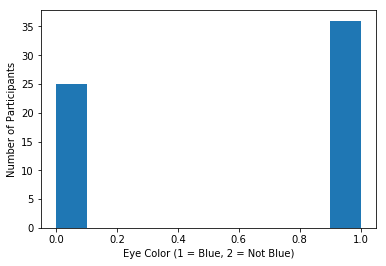

In [8]:
# create histogram of blue/not blue. TODO: make labels for graph
plt.hist(leftEyeList)
plt.ylabel("Number of Participants")
plt.xlabel("Eye Color (1 = Blue, 2 = Not Blue)")
plt.show()

In [9]:
# dump the classifier for analysis
from sklearn.externals import joblib
svc_test = LinearSVC(penalty='l1', class_weight='balanced', 
                     C=.06, dual=False, verbose=1, max_iter=2500)
svc_test.fit(knownData, leftEyeList)

[LibLinear]

LinearSVC(C=0.06, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2500,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=1)

In [10]:
joblib.dump(svc_test, fileName)

['svc_no_hazel.pkl']